In [1]:
%matplotlib notebook

In [2]:
import PyLidar3
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import threading
import time
from pykalman import KalmanFilter
from collections import defaultdict

In [3]:
def init_kalman_filter():
    transition_matrix = [[1, 0, 1, 0],
                         [0, 1, 0, 1],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]]
    
    observation_matrix = [[1, 0, 0, 0],
                          [0, 1, 0, 0]]
    
    initial_state_mean = [0, 0, 0, 0]
    initial_state_covariance = np.eye(4)
    
    kf = KalmanFilter(transition_matrices=transition_matrix,
                      observation_matrices=observation_matrix,
                      initial_state_mean=initial_state_mean,
                      initial_state_covariance=initial_state_covariance)
    
    return kf


In [4]:
kf = init_kalman_filter()
cluster_states = defaultdict(lambda: {"state_mean": kf.initial_state_mean, "state_cov": kf.initial_state_covariance})

In [5]:
def collect_data():
    gen = Obj.StartScanning()
    data = next(gen)
    distance = []
    for points in data:
        distance.append(data[points])
    Obj.StopScanning()
    return distance

def process_data(distance):
    ol.clusterOp_0.register_map

    CONTROL_REGISTER = 0x0
    ol.clusterOp_0.write(CONTROL_REGISTER, 0x81)  # 0x81 will set bit 0

    dma = ol.axi_dma
    input_buffer = allocate(shape=(360,), dtype=np.int32)
    np.copyto(input_buffer, distance)
    output_buffer = allocate(shape=(380,), dtype=np.int32)

    ol.clusterOp_0.write(CONTROL_REGISTER, 0x81)

    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    clusterOp_data = output_buffer

    del input_buffer, output_buffer

    return clusterOp_data


In [6]:
def update_plot(ax1, ax2, distance, clusterOp_data):
    cluster_n = []  # initialize empty list for first cluster
    clusters = []  # initialize list to hold all clusters

    for value in clusterOp_data:
        if value == 720:
            if cluster_n:  # check if cluster_n already has values
                clusters.append(cluster_n)  # if so, add it to clusters
                cluster_n = []  # reset cluster_n to empty list
        else:
            cluster_n.append(value)  # add value to current cluster

    if cluster_n:  # handle the last cluster after the loop ends
        clusters.append(cluster_n)

    #print(clusters)  # display all clusters

    cluster_indices = [i for i, cluster in enumerate(clusters) if len(cluster) >= 5]
    ax1.clear()
    ax1.scatter(np.deg2rad(angle), distance, s=5)
    ax1.set_title("Raw Data")
    ax1.set_ylim(0, max(distance))

    ax2.clear()
    for index in cluster_indices:
        group = clusters[index]

        # Calculate the centroid of the current cluster
        clusterTheta = np.array(group)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        clusterX = np.mean(clusterDistance * np.cos(np.deg2rad(clusterTheta)))
        clusterY = np.mean(clusterDistance * np.sin(np.deg2rad(clusterTheta)))

        # Kalman filter prediction and update steps
        state_mean, state_cov = cluster_states[index]['state_mean'], cluster_states[index]['state_cov']
        state_mean, state_cov = kf.filter_update(state_mean, state_cov, np.array([clusterX, clusterY]))
        cluster_states[index]['state_mean'], cluster_states[index]['state_cov'] = state_mean, state_cov

        # Calculate the predicted position
        predicted_theta, predicted_r = np.rad2deg(np.arctan2(state_mean[1], state_mean[0])), np.hypot(state_mean[0], state_mean[1])

        # Plot the original cluster and predicted position
        ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)
        ax2.scatter(np.deg2rad(predicted_theta), predicted_r, s=30, marker='x', color='red')

    ax2.set_title("Clustered Data")
    ax2.set_ylim(0, max(distance))

    fig.canvas.draw()


In [7]:
angle = np.arange(0, 360)

port = "/dev/ttyUSB0"  # linux
Obj = PyLidar3.YdLidarX4(port, 12000)

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp/clusterOp.bit')


{'model_number': '6', 'firmware_version': '1.5', 'hardware_version': '1', 'serial_number': '201904120'}


{'model_number': '6', 'firmware_version': '1.5', 'hardware_version': '1', 'serial_number': '201904120'}


<IPython.core.display.Javascript object>


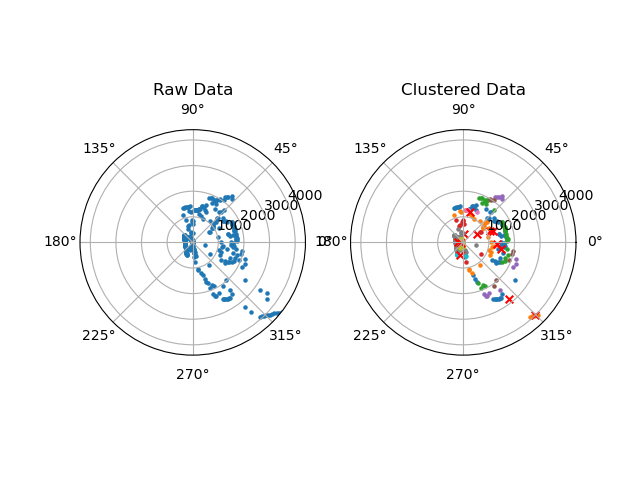

Iteration: 0
Iteration: 1
Error during iteration: operands could not be broadcast together with shapes (4,) (5,) 
Error during iteration: operands could not be broadcast together with shapes (4,) (7,) 
Iteration: 4
Error during iteration: operands could not be broadcast together with shapes (6,) (10,) 
Error during iteration: operands could not be broadcast together with shapes (3,) (5,) 
Error during iteration: operands could not be broadcast together with shapes (4,) (5,) 
Error during iteration: operands could not be broadcast together with shapes (4,) (6,) 
Error during iteration: operands could not be broadcast together with shapes (2,) (5,) 
Iteration: 10
Error during iteration: operands could not be broadcast together with shapes (3,) (6,) 
Error during iteration: operands could not be broadcast together with shapes (5,) (6,) 
Error during iteration: operands could not be broadcast together with shapes (3,) (7,) 
Iteration: 14
Iteration: 15
Error during iteration: operands could

In [11]:
if Obj.Connect():
    print(Obj.GetDeviceInfo())
else:
    print("Error connecting to device")
    exit(1)
    
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))
plt.ion()
iterations = 20  # Adjust the number of iterations as needed
    
for _ in range(iterations):
    distance = collect_data()
    clusterOp_data = process_data(distance)
    time.sleep(0.2)
    try:
        update_plot(ax1, ax2, distance, clusterOp_data)
        print("Iteration: " + str(_))
    except Exception as e:
        print(f"Error during iteration: {e}")
        continue
print("Done!")
Obj.Disconnect()